#### Environment Setup

In [3]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings

# For preprocessing and modeling
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.decomposition import PCA

# For advanced visualization
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.ticker as mtick
import matplotlib.gridspec as gridspec

# Configure visualization settings
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('Set2')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Ignore warnings
warnings.filterwarnings('ignore')

# Display settings for pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

print("Environment setup complete!")

Environment setup complete!


### 2. Data Loading and Understanding

##### 2.1 Data Loading

In [7]:
# Create an Excel object file in Pandas
data = pd.ExcelFile('data/online_retail_data.xlsx')

# # Read each excel sheet as a singular dataframe
df1 = pd.read_excel(data, sheet_name='Year 2009-2010')
df2 = pd.read_excel(data, sheet_name='Year 2010-2011')

# Concatenate both dataframes
online_retail = pd.concat([df1, df2], ignore_index=True)

##### 2.2 Data Exploration

In [8]:
online_retail.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.950,13085.000,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.750,13085.000,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.750,13085.000,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.100,13085.000,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.250,13085.000,United Kingdom


In [10]:
# Display basic information about the dataset
print("Dataset shape:", online_retail.shape)
print("\nData types:")
print(online_retail.dtypes)

print("\nFirst 5 rows:")
print(online_retail.head())

print("\nStatistical summary:")
print(online_retail.describe())

print("\nMissing values:")
print(online_retail.isnull().sum())
print(f"Percentage of missing CustomerID: {online_retail['Customer ID'].isnull().mean()*100:.2f}%")

Dataset shape: (1067371, 8)

Data types:
Invoice                object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
Price                 float64
Customer ID           float64
Country                object
dtype: object

First 5 rows:
  Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

          InvoiceDate  Price  Customer ID         Country  
0 2009-12-01 07:45:00  6.950    13085.000  United Kingdom  
1 2009-12-01 07:45:00  6.750    13085.000  United Kingdom  
2 2009-12-01 07:45:00  6.750    13085.000  United Kingdom  
3 2009-12-01 07:45:00  2.100 

In [ ]:
# Check for basic data quality issues

# Unique values in categorical columns
print("\nUnique values in categorical columns:")
print(f"Number of unique invoices: {online_retail['Invoice'].nunique()}")
print(f"Number of unique products: {online_retail['StockCode'].nunique()}")
print(f"Number of unique customers: {online_retail['Customer ID'].dropna().nunique()}")
print(f"Number of unique countries: {online_retail['Country'].nunique()}")

# Check for cancelled invoices (often start with 'C')
cancelled = online_retail['Invoice'].astype(str).str.startswith('C')
print(f"\nNumber of cancelled invoices: {cancelled.sum()}")

# Check for abnormal quantities and prices
print("\nQuantity range:")
print(f"Min: {online_retail['Quantity'].min()}, Max: {online_retail['Quantity'].max()}")
print(f"Number of negative quantities (returns): {(online_retail['Quantity'] < 0).sum()}")

print("\nPrice range:")
print(f"Min: {online_retail['Price'].min()}, Max: {online_retail['Price'].max()}")
print(f"Number of zero or negative prices: {(online_retail['Price'] <= 0).sum()}")

# Create TotalValue column if it doesn't exist
if 'TotalValue' not in online_retail.columns:
    online_retail['TotalValue'] = online_retail['Quantity'] * online_retail['Price']
    print("\nCreated TotalValue column")


Unique values in categorical columns:
Number of unique invoices: 53628
Number of unique products: 5305
Number of unique customers: 5942
Number of unique countries: 43

Number of cancelled invoices: 19494

Quantity range:
Min: -80995, Max: 80995
Number of negative quantities (returns): 22950

UnitPrice range:
Min: -53594.36, Max: 38970.0
Number of zero or negative prices: 6207

Created TotalValue column


#### **3. Exploratory Data Analysis (EDA)**

##### 3.1 Distribution of key variables

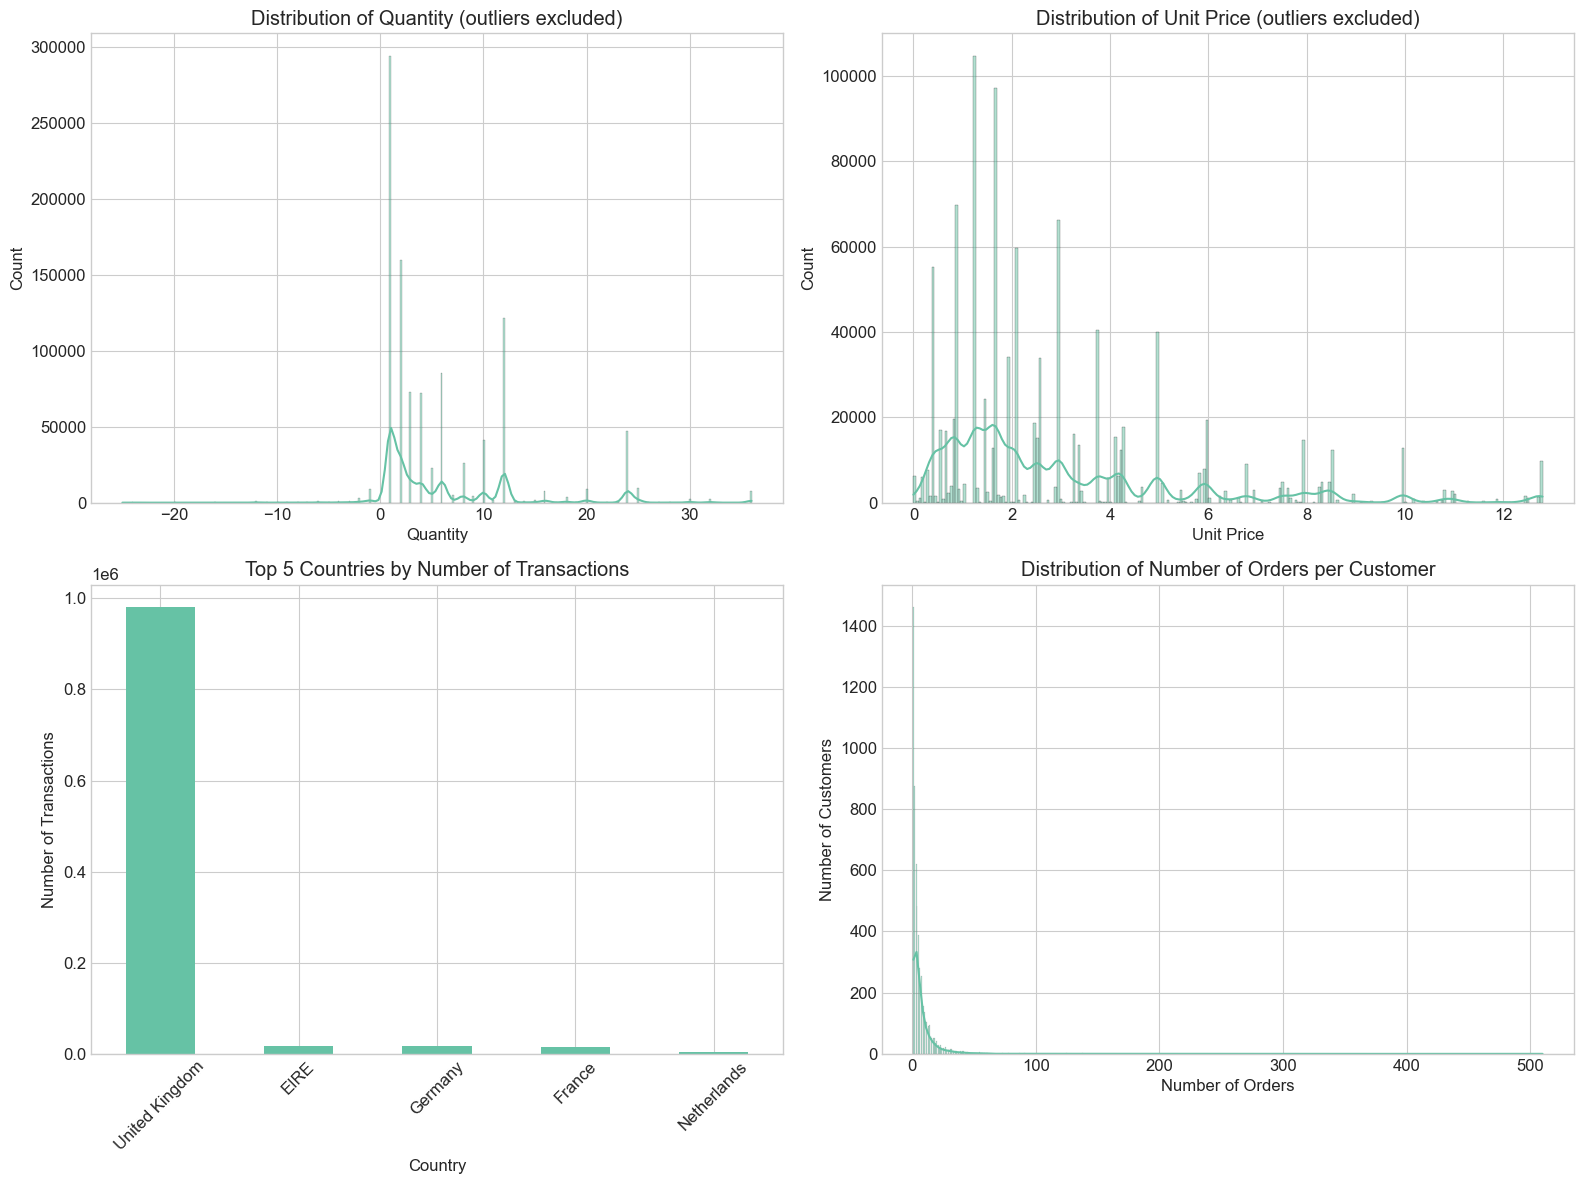

In [18]:
# Set up a multi-plot figure
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Quantity distribution (excluding extreme outliers for visualization)
q1 = online_retail['Quantity'].quantile(0.25)
q3 = online_retail['Quantity'].quantile(0.75)
iqr = q3 - q1
quantity_filter = (online_retail['Quantity'] > q1 - 3 * iqr) & (online_retail['Quantity'] < q3 + 3 * iqr)

sns.histplot(online_retail.loc[quantity_filter, 'Quantity'], kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Distribution of Quantity (outliers excluded)')
axes[0, 0].set_xlabel('Quantity')

# UnitPrice distribution (excluding extreme outliers for visualization)
q1 = online_retail['Price'].quantile(0.25)
q3 = online_retail['Price'].quantile(0.75)
iqr = q3 - q1
price_filter = (online_retail['Price'] > q1 - 3 * iqr) & (online_retail['Price'] < q3 + 3 * iqr)

sns.histplot(online_retail.loc[price_filter, 'Price'], kde=True, ax=axes[0, 1])
axes[0, 1].set_title('Distribution of Unit Price (outliers excluded)')
axes[0, 1].set_xlabel('Unit Price')

# Country distribution
country_counts = online_retail['Country'].value_counts().head(5)
country_counts.plot(kind='bar', ax=axes[1, 0])
axes[1, 0].set_title('Top 5 Countries by Number of Transactions')
axes[1, 0].set_xlabel('Country')
axes[1, 0].set_ylabel('Number of Transactions')
axes[1, 0].tick_params(axis='x', rotation=45)

# Customer purchase frequency
# For each customer, count number of unique invoices
customer_orders = online_retail.dropna(subset=['Customer ID']).groupby('Customer ID')['Invoice'].nunique()
sns.histplot(customer_orders, kde=True, ax=axes[1, 1])
axes[1, 1].set_title('Distribution of Number of Orders per Customer')
axes[1, 1].set_xlabel('Number of Orders')
axes[1, 1].set_ylabel('Number of Customers')

plt.tight_layout()
plt.show()

##### 3.2 Time Series Analysis

In [19]:
online_retail.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalValue
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.950,13085.000,United Kingdom,83.400
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.750,13085.000,United Kingdom,81.000
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.750,13085.000,United Kingdom,81.000
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.100,13085.000,United Kingdom,100.800
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.250,13085.000,United Kingdom,30.000


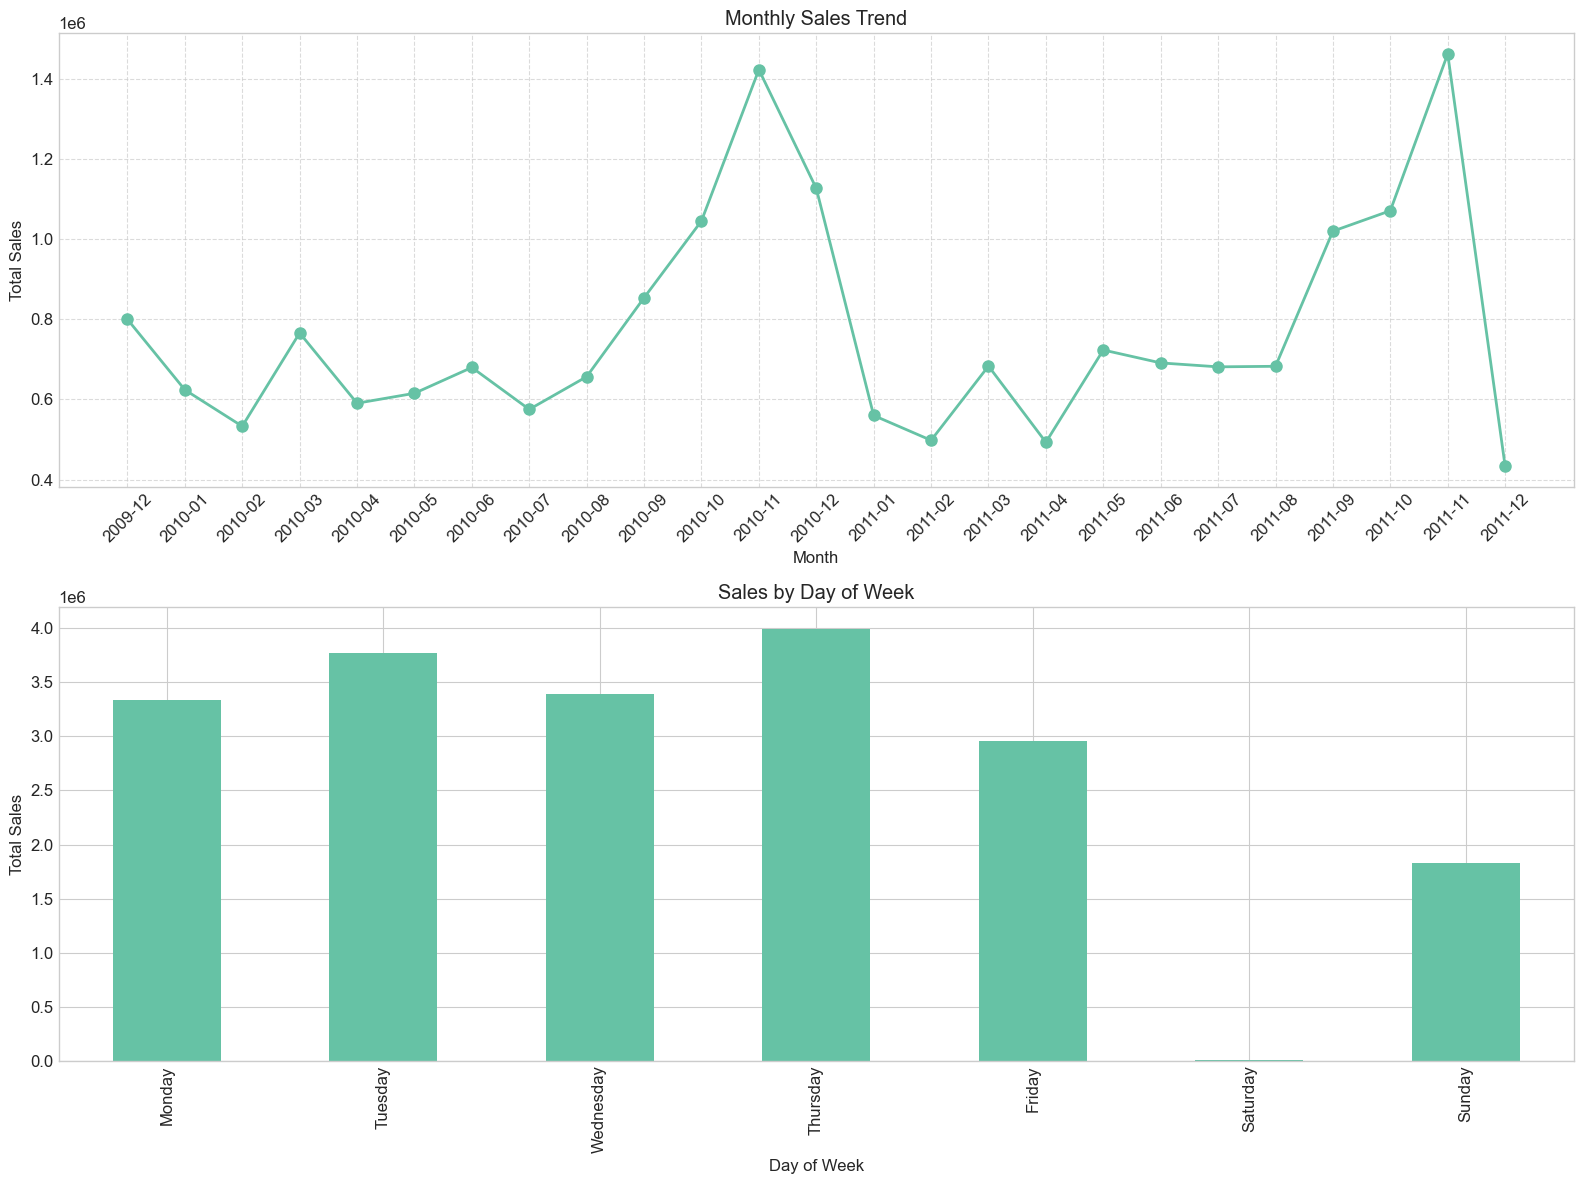

In [20]:
# Ensure InvoiceDate is datetime
online_retail['InvoiceDate'] = pd.to_datetime(online_retail['InvoiceDate'])

# Extract date components
online_retail['Year'] = online_retail['InvoiceDate'].dt.year
online_retail['Month'] = online_retail['InvoiceDate'].dt.month
online_retail['Day'] = online_retail['InvoiceDate'].dt.day
online_retail['DayOfWeek'] = online_retail['InvoiceDate'].dt.dayofweek
online_retail['Hour'] = online_retail['InvoiceDate'].dt.hour

# Create month-year for time series
online_retail['MonthYear'] = online_retail['InvoiceDate'].dt.strftime('%Y-%m')

# Set up plotting
fig, axes = plt.subplots(2, 1, figsize=(16, 12))

# Monthly sales analysis
monthly_sales = online_retail.groupby('MonthYear')['TotalValue'].sum().reset_index()
axes[0].plot(monthly_sales['MonthYear'], monthly_sales['TotalValue'], 'o-', linewidth=2, markersize=8)
axes[0].set_title('Monthly Sales Trend')
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Total Sales')
axes[0].grid(True, linestyle='--', alpha=0.7)
axes[0].tick_params(axis='x', rotation=45)

# Day of week analysis
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_sales = online_retail.groupby('DayOfWeek')['TotalValue'].sum().reindex(range(7))
day_sales.index = day_names
day_sales.plot(kind='bar', ax=axes[1])
axes[1].set_title('Sales by Day of Week')
axes[1].set_xlabel('Day of Week')
axes[1].set_ylabel('Total Sales')

plt.tight_layout()
plt.show()

##### 3.3 Customer Purchase Analysis

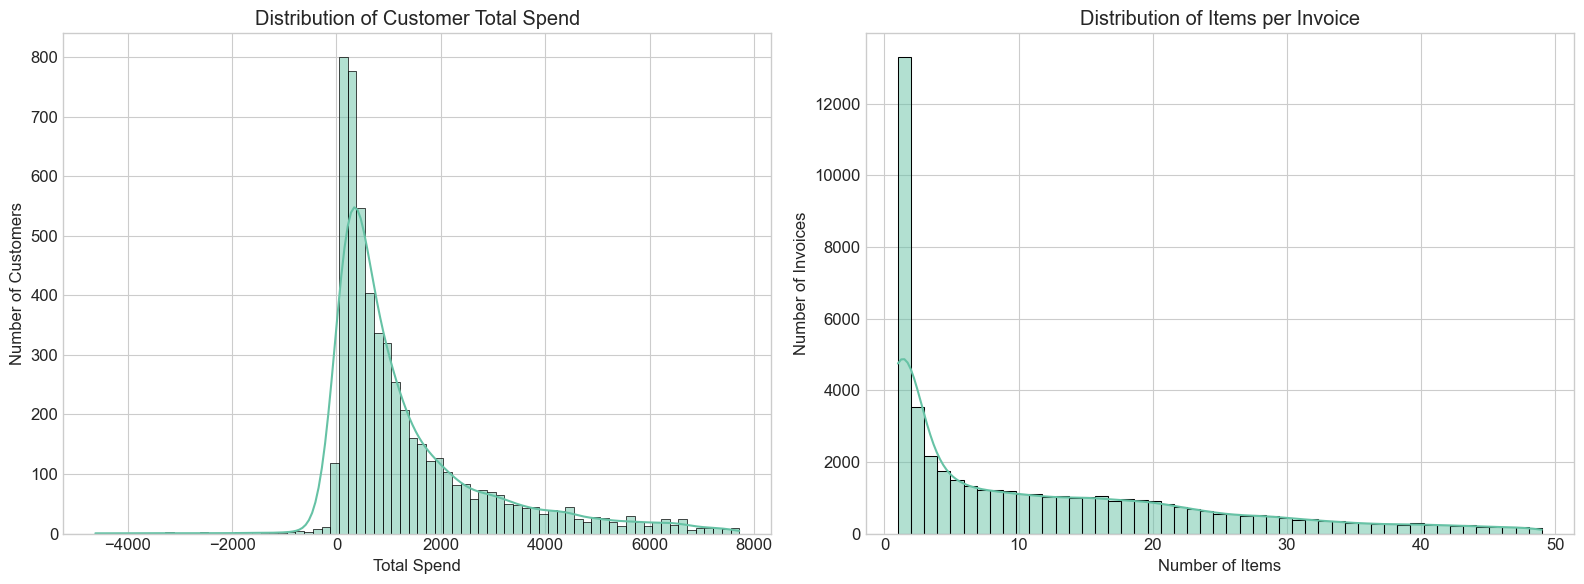

Customer Purchase Behavior Summary:

Total Spend per Customer:
count     5942.000
mean      2801.799
std      13973.923
min     -25111.090
25%        325.098
50%        843.970
75%       2182.005
max     598215.220
Name: TotalValue, dtype: float64

Items per Invoice:
count   53628.000
mean       19.903
std        41.253
min         1.000
25%         2.000
50%         9.000
75%        23.000
max      1350.000
dtype: float64


In [21]:
# Create a figure for customer purchase analysis
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Analyze customer monetary value
customer_monetary = online_retail.dropna(subset=['Customer ID']).groupby('Customer ID')['TotalValue'].sum()

# Filter out extreme outliers for better visualization
q1 = customer_monetary.quantile(0.25)
q3 = customer_monetary.quantile(0.75)
iqr = q3 - q1
monetary_filter = (customer_monetary > q1 - 3 * iqr) & (customer_monetary < q3 + 3 * iqr)

sns.histplot(customer_monetary[monetary_filter], kde=True, ax=axes[0])
axes[0].set_title('Distribution of Customer Total Spend')
axes[0].set_xlabel('Total Spend')
axes[0].set_ylabel('Number of Customers')

# Analysis of items per invoice
items_per_invoice = online_retail.groupby('Invoice').size()
sns.histplot(items_per_invoice[items_per_invoice < 50], kde=True, ax=axes[1])  # Limiting to <50 for better visualization
axes[1].set_title('Distribution of Items per Invoice')
axes[1].set_xlabel('Number of Items')
axes[1].set_ylabel('Number of Invoices')

plt.tight_layout()
plt.show()

# Display summary statistics
print("Customer Purchase Behavior Summary:")
print("\nTotal Spend per Customer:")
print(customer_monetary.describe())

print("\nItems per Invoice:")
print(items_per_invoice.describe())

#### **4. Data Preprocessing and Cleaning**

##### 4.1 Handling Missing Values and Filtering Data

In [22]:
online_retail.tail()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalValue,Year,Month,Day,DayOfWeek,Hour,MonthYear
1067366,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.100,12680.000,France,12.600,2011,12,9,4,12,2011-12
1067367,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.150,12680.000,France,16.600,2011,12,9,4,12,2011-12
1067368,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.150,12680.000,France,16.600,2011,12,9,4,12,2011-12
1067369,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.950,12680.000,France,14.850,2011,12,9,4,12,2011-12
1067370,581587,POST,POSTAGE,1,2011-12-09 12:50:00,18.000,12680.000,France,18.000,2011,12,9,4,12,2011-12


In [24]:
# Make a copy to avoid modifying the original dataset
df_cleaned = online_retail.copy()

# Convert InvoiceDate to datetime if not already
df_cleaned['InvoiceDate'] = pd.to_datetime(df_cleaned['InvoiceDate'])

print("Starting data preprocessing...")
print(f"Original dataset shape: {df_cleaned.shape}")

# 1. Remove rows with missing CustomerID since we need this for customer segmentation
df_cleaned = df_cleaned.dropna(subset=['Customer ID'])
print(f"After removing rows with missing CustomerID: {df_cleaned.shape}")

# 2. Fill missing descriptions with 'Unknown'
df_cleaned['Description'] = df_cleaned['Description'].fillna('Unknown')

# 3. Filter out cancelled transactions (invoices starting with 'C')
df_cleaned = df_cleaned[~df_cleaned['Invoice'].astype(str).str.startswith('C')]
print(f"After removing cancelled transactions: {df_cleaned.shape}")

# 4. Remove rows with zero or negative unit prices
df_cleaned = df_cleaned[df_cleaned['Price'] > 0]
print(f"After removing zero/negative unit prices: {df_cleaned.shape}")

# 5. Remove rows with zero quantities (but keep negative quantities for returns)
df_cleaned = df_cleaned[df_cleaned['Quantity'] != 0]
print(f"After removing zero quantities: {df_cleaned.shape}")

# 6. Convert CustomerID to integer
df_cleaned['Customer ID'] = df_cleaned['Customer ID'].astype(int)

# 7. Check for duplicates
duplicates = df_cleaned.duplicated().sum()
if duplicates > 0:
    df_cleaned = df_cleaned.drop_duplicates()
    print(f"Removed {duplicates} duplicate transactions")

print("Basic data cleaning completed!")

Starting data preprocessing...
Original dataset shape: (1067371, 15)
After removing rows with missing CustomerID: (824364, 15)
After removing cancelled transactions: (805620, 15)
After removing zero/negative unit prices: (805549, 15)
After removing zero quantities: (805549, 15)
Removed 26124 duplicate transactions
Basic data cleaning completed!
